In [ ]:
import pandas as pd
import re
import seaborn as sns
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
amadf = pd.read_csv('/content/drive/My Drive/Group2 - Parsing product and user review data/amazon_co-ecommerce_sample.csv')
amadf.dropna(subset=['customer_reviews'], inplace=True)

In [ ]:
amadf_sorted = amadf.drop(columns = ['uniq_id', 'number_available_in_stock', 'number_of_answered_questions', 'customers_who_bought_this_item_also_bought', 'description', 'product_information', 'product_description', 'items_customers_buy_after_viewing_this_item', 'customer_questions_and_answers'])
amadf_sorted.reset_index(inplace=True)
amadf_sorted.head(75)

,index,product_name,manufacturer,price,number_of_reviews,average_review_rating,amazon_category_and_sub_category,customer_reviews,sellers
0,0,Hornby 2014 Catalogue,Hornby,£3.42,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,1,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,3,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Birthday present // 5.0 // 14 April 2014 // By...,NaN
...,...,...,...,...,...,...,...,...,...
70,70,Hornby R1174 Breakdown Hauler Train Set,Hornby,£74.99,4,4.8 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,"Excellent small starter trainset, with a prett...","{""seller""=>[{""Seller_name_1""=>""Toy Arena"", ""Se..."
71,72,[NEW] Pureoroko C-58 water steam [NEW],Train,£27.60,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,but now working well and a great item. // 5.0 ...,"{""seller""=>[{""Seller_name_1""=>""Sukiyaki JP"", ""..."
72,73,Train Tech SK2 Home Signal Kit with R/G LEDs,Train Tech,£8.00,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Lighti...,Five Stars // 5.0 // 25 Mar. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Gaugemaster"", ""S..."
73,74,Kato 11-105 Small Type Moter Unit (for Bandai'...,Kato,£11.01,3,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Top quality chassis // 5.0 // 27 Aug. 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""Santa Trading J..."


In [ ]:
amadf_sorted['sor_review'] = amadf_sorted['customer_reviews'].str.split(pat='//')
amadf_sorted.head()

,index,product_name,manufacturer,price,number_of_reviews,average_review_rating,amazon_category_and_sub_category,customer_reviews,sellers,sor_review
0,0,Hornby 2014 Catalogue,Hornby,£3.42,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",[Worth Buying For The Pictures Alone (As Ever)...
1,1,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...","[Four Stars , 4.0 , 18 Dec. 2015 , By\n ..."
2,2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...","[**Highly Recommended!** , 5.0 , 26 May 2015..."
3,3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN,"[I love it , 5.0 , 22 July 2013 , By\n \..."
4,4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,3,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Birthday present // 5.0 // 14 April 2014 // By...,NaN,"[Birthday present , 5.0 , 14 April 2014 , B..."


In [ ]:
ex_rev = []
ex_rev_unl = []
pro = []
for ind,i in enumerate(amadf_sorted['sor_review']):
   ex_rev_unl.append(i.pop())
   a = i[::4]
   for j in a:
     if 'if(ue) {' in j.strip():
       continue
     pro.append(amadf_sorted['product_name'][ind])
     ex_rev.append(j)
len(ex_rev)

29549

In [ ]:
rat = []
for i,j in enumerate(amadf_sorted['sor_review']):
  for k,l in enumerate(j):
    if re.findall(r'\d\.\d', l) != []:
      rat.extend(re.findall(r'\d\.\d', l))

In [ ]:
rat = list(map(float, rat))
rat
del rat[-398:-1]
print(len(rat))

29549


In [ ]:
rev_df = pd.DataFrame({'Review':ex_rev, 'Rating': rat, 'product_name':pro})
rev_df

,Review,Rating,product_name
0,Worth Buying For The Pictures Alone (As Ever),4.0,Hornby 2014 Catalogue
1,Part of the magic for me growing up as a boy ...,5.0,Hornby 2014 Catalogue
2,"Amazing detail, every credit to the photograp...",5.0,Hornby 2014 Catalogue
3,This was purchased on behalf of my Dad. He is...,5.0,Hornby 2014 Catalogue
4,Everything I really needed to see what was on...,5.0,Hornby 2014 Catalogue
...,...,...,...
29544,1st class kit top marks to bandai if your not...,5.0,Star Wars 1/72 Y-Wing Starfighter
29545,"Fantastic kit, well fiddly and tiny parts, ha...",5.0,Star Wars 1/72 Y-Wing Starfighter
29546,Ok so if you don't read these (like i didnt) ...,4.0,Star Wars 1/72 Y-Wing Starfighter
29547,"I bought this model back in 15th December, ha...",5.0,Star Wars 1/72 Y-Wing Starfighter


***Removing HTML***

In [ ]:
for k,i in enumerate(rev_df['Review']):
  i = re.sub(r'(www.\S+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)',"" , i)
  rev_df['Review'][k] = i.strip()
rev_df.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Review,Rating,product_name
0,Worth Buying For The Pictures Alone (As Ever),4.0,Hornby 2014 Catalogue
1,Part of the magic for me growing up as a boy w...,5.0,Hornby 2014 Catalogue
2,"Amazing detail, every credit to the photograph...",5.0,Hornby 2014 Catalogue
3,This was purchased on behalf of my Dad. He is ...,5.0,Hornby 2014 Catalogue
4,Everything I really needed to see what was on ...,5.0,Hornby 2014 Catalogue


In [ ]:
new = pd.merge(amadf_sorted, rev_df)

In [ ]:
pd.set_option('display.max_rows', new.shape[0]+1)
new = new.drop(columns=['sor_review', 'customer_reviews'])


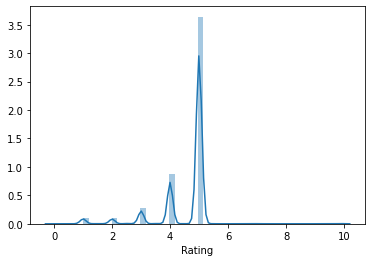

In [ ]:
ex_rev_copy = ex_rev.copy()

In [ ]:
token_without_sw = ''
punctuations = string.punctuation
 
stop_words = spacy.lang.en.stop_words.STOP_WORDS
 
def punc_sw_rem(sentence):
  sentence = sentence.lower()
 
  sentence = sentence.translate(str.maketrans('', '', punctuations))
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  
  tok_word = word_tokenize(sentence,"english")
  tokens_without_sw = "  ".join(word for word in tok_word if not word in stop_words)
  return emoji_pattern.sub(r'', tokens_without_sw)
 
ex_rev_copy = ex_rev
for i,text in enumerate(ex_rev_copy):
  ex_rev_copy[i] = punc_sw_rem(text)
 
ex_rev_copy